In [1]:
import glob
import numpy as np
from scipy.interpolate import griddata

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Polygon, ConnectionPatch

from mpl_toolkits.axes_grid1 import make_axes_locatable

from blg_strain.utils.saver import load, Saver
from blg_strain.lattice import StrainedLattice, brillouin_zone
from blg_strain.bands import BandStructure, FilledBands, get_bands
from blg_strain.macroscopic import integrand_by_parts
from blg_strain.utils.const import q, hbar, muB, a0, hbar_J, mu0

gr = (5**.5 + 1) / 2
width_in = 3.375  # column width in inches

In [2]:
# mpl.font_manager._rebuild()

In [3]:
# %matplotlib notebook

In [4]:
mpl.rc_file('sBLG.rc')

In [5]:
pcolormesh_params = dict(rasterized=True, shading='gouraud')

In [128]:
def savefig(fig, filename, columns=1, dpi=400, tweak_height=1, shift_x=0):
    assert columns in [1, 1.5, 2]
    width = 3.375 * columns  # width in inches
    
    # get the center of the plot area
    x0, y0, w, h = [fig.bbox.bounds[i]/100 for i in range(4)]
    xcenter = x0 + w/2
    ycenter = y0 + h/2
    
    # bbox that is the width of the specified number of columns and with an automatic height
    bbox = mpl.transforms.Bbox.from_bounds(xcenter - width/2 + shift_x, y0, width, h * tweak_height)
    
    fig.savefig(filename, bbox_inches=bbox, transparent=True, dpi=dpi)

# FigureKspace - Brillouin Zone and magnetic moment

In [337]:
eps = 0.01
theta = 0
Delta = 0.007  # eV
EF = 0.007  # eV

cmap='cividis'

In [338]:
sl = StrainedLattice(eps, theta)
sl.calculate()

sl0 = StrainedLattice(0, 0)
sl0.calculate()

bs = BandStructure(sl, Delta=Delta)
bs.calculate(600, 600)

fb = FilledBands(bs, EF=EF)
fb.calculate(600, 600)

In [339]:
K = 4 * np.pi / (3 * np.sqrt(3))
kxa = np.linspace(-1.2 * K, 1.2 * K, 500)
kya = kxa
Kxa, Kya = np.meshgrid(kxa, kya)

In [340]:
E, Psi = get_bands(Kxa, Kya, sl, Delta=Delta)

In [341]:
bz0 = brillouin_zone(sl0.strain)
bz = brillouin_zone(sl.strain)

M = bs.Mu[2] + q * bs.Omega[2] / hbar * (EF - bs.E[2])
M = M / muB  # A * m^2 -> Bohr magnetons
dM = integrand_by_parts(bs.kxa, bs.kya, bs.splE[2], bs.splO[2], bs.splM[2], EF=EF)
prefactor = - a0 * q * mu0 / (hbar_J) / (2 * np.pi * a0) ** 2
dM = dM / prefactor / muB / np.sqrt(3) # A * m^2 / a0 -> Bohr magnetons / a

In [342]:
labels = cax.get_xticklabels()
labels[0]

Text(-3, 1, '−3')

Text(-1.8, -0.1, 'K’')

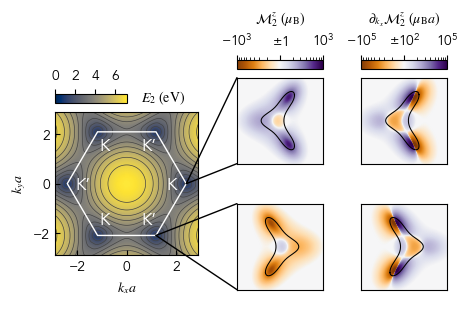

In [355]:
fig = plt.figure(figsize=(1.5*width_in, 3))
# Fake axes to define area spanned by all subplots
ax = fig.add_subplot(111, frameon=False)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.grid(False)

gs = fig.add_gridspec(2, 5, width_ratios=[2.5, .2, 1.5, .2, 1.5])
ax0 = fig.add_subplot(gs[:, 0])
ax02 = fig.add_subplot(gs[0, 2])
ax12 = fig.add_subplot(gs[1, 2])
ax04 = fig.add_subplot(gs[0, 4])
ax14 = fig.add_subplot(gs[1, 4])

# Full BZ
im = ax0.pcolormesh(Kxa, Kya, E[2], **pcolormesh_params, cmap=cmap, vmin=0)
ax0.contour(Kxa, Kya,  E[2], colors='#444444', levels=10, linewidths=0.5, alpha=1, zorder=1)
ax0.set_aspect('equal')

ax0.set_xlabel(r'$k_xa$')
ax0.set_ylabel(r'$k_ya$')

# Draw Brillouin zone
p = Polygon(bz, fill=False, color='w', lw=1, zorder=10) # zorder=10 to put on top
ax0.add_patch(p)

# # Draw box around K point
# p = Polygon([sl.K + [0.05, 0.05], sl.K + [-0.05, 0.05], sl.K + [-0.05, -0.05], sl.K + [0.05, -0.05]], fill=False, color='k', lw=0.5, ls='--', zorder=11)
# ax0.add_patch(p)


# Draw "zoom in" to K/K'
cp1 = ConnectionPatch(sl.K, (0, 1), "data", "axes fraction", axesA=ax0, axesB=ax02, zorder=20)
cp2 = ConnectionPatch(sl.K, (0, 0), "data", "axes fraction", axesA=ax0, axesB=ax02, zorder=20)
ax0.add_artist(cp1)
ax0.add_artist(cp2)
cp1 = ConnectionPatch(sl.bz[1], (0, 1), "data", "axes fraction", axesA=ax0, axesB=ax12, zorder=20)
cp2 = ConnectionPatch(sl.bz[1], (0, 0), "data", "axes fraction", axesA=ax0, axesB=ax12, zorder=20)
ax0.add_artist(cp1)
ax0.add_artist(cp2)

## colorbar
l, b, w, h = ax0.get_position().bounds
cax = fig.add_axes([l, b + h + .03, w/2, .03])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cax.tick_params(direction='out')
cax.xaxis.set_ticks_position('top')
cax.yaxis.set_label_position("right")
cax.text(1.2, 0.5, '$E_2\ (\mathrm{eV})$', transform=cax.transAxes, va='center')
cbar.set_ticks([0, 2, 4, 6])

# K and K' - M
norm_M=mpl.colors.SymLogNorm(linthresh=1, linscale=0, vmin=-1e3, vmax=1e3)
im02 = ax02.pcolormesh(bs.Kxa, bs.Kya, M, **pcolormesh_params, cmap='PuOr', norm=norm_M)
ax12.pcolormesh(-bs.Kxa, -bs.Kya, -M, **pcolormesh_params, cmap='PuOr', norm=norm_M)

# K and K' - dM
norm_dM=mpl.colors.SymLogNorm(linthresh=1e2, linscale=0,  vmin=-1e5, vmax=1e5)
im04 = ax04.pcolormesh(bs.Kxa, bs.Kya, dM, **pcolormesh_params, cmap='PuOr', norm=norm_dM)
ax14.pcolormesh(-bs.Kxa, -bs.Kya, dM, **pcolormesh_params, cmap='PuOr', norm=norm_dM)
# dM picks up a negative sign in K' because the derivative does not undergo spatial inversion


# E=EF contours
ax02.plot(fb.contours[2][0][:,0], fb.contours[2][0][:,1], 'k')
ax12.plot(-fb.contours[2][0][:,0], -fb.contours[2][0][:,1], 'k')
ax04.plot(fb.contours[2][0][:,0], fb.contours[2][0][:,1], 'k')
ax14.plot(-fb.contours[2][0][:,0], -fb.contours[2][0][:,1], 'k')

# Zoom in by a factor of 2
for a in [ax02, ax12, ax04, ax14]:
    x0, x1 = a.get_xlim()
    y0, y1 = a.get_ylim()
    a.set_xlim((x0 + x1) / 2 - (x1 - x0) / 4, (x0 + x1) / 2 + (x1 - x0) / 4)
    a.set_ylim((y0 + y1) / 2 - (y1 - y0) / 4, (y0 + y1) / 2 + (y1 - y0) / 4)
    a.set_xticks([])
    a.set_yticks([])
    a.set_aspect('equal')
    
    
## colorbar M
l, b, w, h = ax02.get_position().bounds
cax = fig.add_axes([l, b + h + .03, w, .03])
cbar = plt.colorbar(im02, cax=cax, orientation='horizontal')
cax.tick_params(direction='out', which='both')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')
cax.set_xlabel(r'$\mathcal{M}^z_2\ (\mu_{\mathrm{B}})$', labelpad=8)
# cax.text(1.2, 0.5, r'$\mathcal{M}^z_2$ ($\mu_{\mathrm{B}}$)', transform=cax.transAxes, va='center')
cbar.set_ticks([-1e3, 0, 1e3])
labels = cax.get_xticklabels()
labels[1] = '$\\mathdefault{\pm1}$'
cax.set_xticklabels(labels)
values = np.arange(2,10)**3
minorticks = norm_M(1 * np.concatenate((-values[::-1], values))) # Log-spaced ticks from 1 to 10^3
cax.xaxis.set_ticks(minorticks, minor=True)
    
## colorbar dM
l, b, w, h = ax04.get_position().bounds
cax = fig.add_axes([l, b + h + .03, w, .03])
cbar = plt.colorbar(im04, cax=cax, orientation='horizontal')
cax.tick_params(direction='out', which='both')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')
cax.set_xlabel(r'$\partial_{k_x}\mathcal{M}^z_2\ (\mu_{\mathrm{B}}a)$', labelpad=8)
# cax.text(1.2, 0.5, r'$\partial_{k_x}\mathcal{M}^z_2$ ($10^3$ $\mu_{\mathrm{B}}/a$)', transform=cax.transAxes, va='center')
cbar.set_ticks([-1e5, 0, 1e5])
labels = cax.get_xticklabels()
labels[1] = '$\\mathdefault{\pm10^2}$'
cax.set_xticklabels(labels)
values = np.arange(2,10)**3
minorticks = norm_dM(1e2 * np.concatenate((-values[::-1], values))) # Log-spaced ticks from 10^2 to 10^5
cax.xaxis.set_ticks(minorticks, minor=True);



# K, K' labels
ax0.text(.9, -1.5, 'K’', color='w', size=12, va='center', ha='center')
ax0.text(.9, 1.5, 'K’', color='w', size=12, va='center', ha='center')
ax0.text(-.9, -1.5, 'K', color='w', size=12, va='center', ha='center')
ax0.text(-.9, 1.5, 'K', color='w', size=12, va='center', ha='center')
ax0.text(1.8, -0.1, 'K', color='w', size=12, va='center', ha='center')
ax0.text(-1.8, -0.1, 'K’', color='w', size=12, va='center', ha='center')

In [357]:
savefig(fig, 'FigureKspace.pdf', 1.5, tweak_height=1.1)

# FigureSusc - susceptibility versus Delta, EF

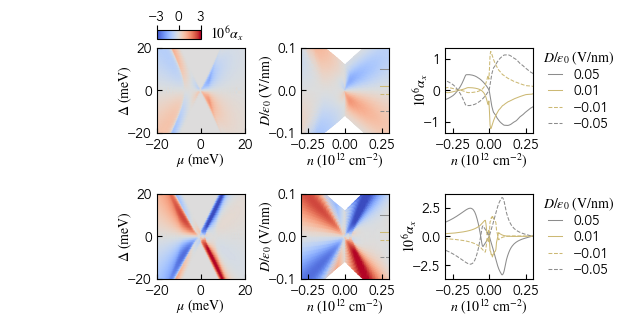

In [29]:
fig = plt.figure(figsize=(width_in*2, 3))

gs = fig.add_gridspec(3, 6, width_ratios=[1.5, 1, .3, 1, .3, 1], height_ratios=[1, .4, 1])
ax_hidden = fig.add_subplot(gs[0,0])
ax_hidden.axis('off')
ax_zz = fig.add_subplot(gs[0, 1])
ax_ac = fig.add_subplot(gs[2, 1])
ax_zz2 = fig.add_subplot(gs[0, 3])
ax_ac2 = fig.add_subplot(gs[2, 3])
ax_zz3 = fig.add_subplot(gs[0, 5])
ax_ac3 = fig.add_subplot(gs[2, 5])

cmap = 'coolwarm'

# Zigzag and armchair
paths = ['data/summary_eps0.010_theta0.000.h5', 'data/summary_eps0.010_theta1.571.h5']
for i, (path, ax, ax2, ax3) in enumerate(zip(paths, [ax_zz, ax_ac], [ax_zz2, ax_ac2], [ax_zz3, ax_ac3])):
    s = Saver.load(path)
    Deltas, EFs, ns, Ds, alphas = s.Deltas, s.EFs, s.ns, s.Ds, s.alphas
    im = ax.pcolormesh(EFs, Deltas, alphas[:,:,0]*1e6, **pcolormesh_params, cmap=cmap, vmin=-3, vmax=3)
    ax.set_xlabel('$\mu\ (\mathrm{meV})$', labelpad=-1)
    ax.set_ylabel('$\Delta\ (\mathrm{meV})$', labelpad=-5)
    # ax_zz.text(0.5, 0.9, r'$\theta=0$', transform=ax_zz.transAxes, ha='center')

    ## n/D map
    im2 = ax2.pcolormesh(ns * 1e-16, Ds * 1e-9, alphas[:,:,0]*1e6, **pcolormesh_params, cmap=cmap, vmin=-3, vmax=3)
    ax2.set_xlabel('$n\ (10^{12}\ \mathrm{cm}^{-2})$', labelpad=-1)
    ax2.set_ylabel(r'$D/\varepsilon_0\ (\mathrm{V/nm})$', labelpad=-5)
    # ax_zz2.text(0.5, 0.9, r'$\theta=0$', transform=ax_zz2.transAxes, ha='center')
    ax2.set_xlim(-.3, .3)
    ax2.set_ylim(-.1, .1)

    ## linecuts (alpha vs. n at fixed D)
    points = np.vstack((ns.flatten() / 1e16, Ds.flatten() / 1e9)).T
    values = alphas[:,:,0].flatten() * 1e6
    Dlines = [.05, .01, -0.01, -0.05]
    lss = ['-', '-', '--', '--']
    c1 = '#8C8C8C'
    c2 = '#CCB974'
    colors = [c1, c2, c2, c1]
    for D, ls, color in zip(Dlines, lss, colors):
        nn = np.linspace(-1, 1, 500)
        DD = np.ones_like(nn) * D
        xi = np.vstack((nn, DD)).T
        zi = griddata(points, values, xi, method='cubic')
        
        label = '{:.2f}'.format(D).replace('-', u'\u2212') # unicode hyphen
        ax3.plot(nn, zi, label=label, ls=ls, color=color)
        ax2.axhline(D, .9, 1, ls=ls, color=color)

    ax3.legend(bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0, title=r'$D/\varepsilon_0\ (\mathrm{V/nm})$', handlelength=1, labelspacing=.1)
    ax3.set_xlabel('$n\ (10^{12}\ \mathrm{cm}^{-2})$', labelpad=-1)
    ax3.set_ylabel(r'$10^6\alpha_x$', labelpad=-5)
    ax3.set_xlim(-.3, .3)
    
# colorbar for the first plot
l, b, w, h = ax_zz.get_position().bounds
cax = fig.add_axes([l, b + h + .03, w*.5, .03])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cax.tick_params(direction='out', which='both', pad=0)
cax.text(1.2, 0.5, r'$10^6\alpha_x$', transform=cax.transAxes, va='center')
cax.xaxis.set_ticks_position('top')
cbar.set_ticks([-3, 0, 3])

In [30]:
savefig(fig, 'FigureSusc.pdf', 2)

## FigureTopo - how change in Fermi surface topology is related to features in the EF/Delta maps

## FigureAngle - angular dependence of the strain, current

In [31]:
g = glob.glob('data\*')

alphas = np.empty((len(g), 2))
alphadotEs1 = np.empty(len(g))
alphadotEs_perp1 = np.empty(len(g))
thetas = np.empty((len(g), 2))
thetas = np.arange(0, 24)*np.pi/24
print(len(g), len(thetas))
Delta = 4  # meV
EF = 4  # meV

for i, filename in enumerate(g):
    theta = float(filename[-8:-3])
#     thetas[i] = theta
    s = Saver.load(filename)
    j = np.where(s.Deltas == Delta)[0]  # index for specified Delta
    k = np.where(s.EFs == EF)[0]  # index for specified EF
#     print(s.Deltas[j], s.EFs[k])
    alphas[i] = s.alphas[j, k]
    
    # Current parallel with strain
    phi = theta
    alphadotEs1[i] = alphas[i].dot([np.cos(phi), np.sin(phi)])
    
    # Current perpendicular to strain
    phi = theta + np.pi/2
    alphadotEs_perp1[i] = alphas[i].dot([np.cos(phi), np.sin(phi)])

24 24


In [32]:
# repeat first period
thetas = np.linspace(0, 2*np.pi, 16*3+1)
alphadotEs = np.empty(16*3+1)
alphadotEs_perp = np.empty(16*3+1)

for j in range(3):
    for i in range(16):
        alphadotEs[16*j + i] = alphadotEs1[i]
        alphadotEs_perp[16*j + i] = alphadotEs_perp1[i]
alphadotEs[-1] = alphadotEs[0]
alphadotEs_perp[-1] = alphadotEs_perp[0]

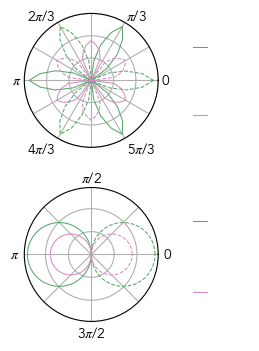

In [161]:
fig= plt.figure(figsize=(width_in, 4))
ax = fig.add_subplot(211, projection='polar')
ax2 = fig.add_subplot(212, projection='polar')


# Rotating strain

c1 = '#55A868'
c2 = '#DA8BC3'
ax.plot(thetas, alphadotEs * (alphadotEs > 0), label=r' ', color=c1)
ax.plot(thetas, alphadotEs_perp * (alphadotEs_perp > 0), label=r' ', color=c2)
ax.plot(thetas, -alphadotEs * (alphadotEs < 0), ls='--', color=c1)
ax.plot(thetas, -alphadotEs_perp * (alphadotEs_perp < 0), ls='--', color=c2)
ax.set_ylim(0, 1.5e-6)
ax.set_yticklabels([])
ax.tick_params(pad=2)

xticks = np.arange(0,12) * np.pi / 6
xticklabels = ['0', '', '$\pi$/3', '', '2$\pi$/3', '', '$\pi$', '', '4$\pi$/3', '', '5$\pi$/3', '']
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, va='center')    
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, handlelength=1, labelspacing=3.5, borderpad=2)

# tweak alignment of tick labels
offset_coords = [[-0.05, 0], [0, 0], [0.05,-0.05], [0,0], [-0.1,-0.05], [0,0], [0.05,0], [0,0], [-0.1,0], [0,0], [0.1,0], [0,0]]
for label, coords in zip(ax.xaxis.get_majorticklabels(), offset_coords):
    offset = mpl.transforms.ScaledTranslation(*coords, fig.dpi_scale_trans)
    label.set_transform(label.get_transform() + offset)


# Rotating E

phis = np.linspace(0, 2*np.pi, 500)
alphadotEs_zz = alphas[0].dot([np.cos(phis), np.sin(phis)])
ax2.plot(phis, alphadotEs_zz * (alphadotEs_zz > 0), color=c1, label=' ')
ax2.plot(phis, -alphadotEs_zz * (alphadotEs_zz < 0), color=c1, ls='--')
alphadotEs_ac = alphas[12].dot([np.cos(phis), np.sin(phis)])
ax2.plot(phis, alphadotEs_ac * (alphadotEs_ac > 0), color=c2, label=' ')
ax2.plot(phis, -alphadotEs_ac * (alphadotEs_ac < 0), color=c2, ls='--')

ax2.set_yticklabels([])

xticks = np.arange(0,8) * np.pi / 4
xticklabels = ['0', '', '$\pi$/2', '', '$\pi$', '', '3$\pi$/2', '']
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticklabels, va='center')

# tweak alignment of tick labels
offset_coords = [[-0.05, 0], [0,0], [0,-0.05], [0,0], [0.05,0], [0,0], [0,0.025], [0,0]]
for label, coords in zip(ax2.xaxis.get_majorticklabels(), offset_coords):
    offset = mpl.transforms.ScaledTranslation(*coords, fig.dpi_scale_trans)
    label.set_transform(label.get_transform() + offset)


ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, handlelength=1, labelspacing=4, borderpad=2)

plt.subplots_adjust(hspace=0.3)

# ax2 = fig.add_axes((.1,.53,.0,.35))
# ax2.xaxis.set_visible(False) # hide x axis
# ax2.set_yticks(np.linspace(0,1,7)) # set new tick positions
# ax2.set_yticklabels(['-1.5', '-1', '-0.5', '0', '0.5', '1', '1.5'])
# ax2.yaxis.set_minor_locator(AutoMinorLocator(2)) # set minor tick for every second tick

# ax.annotate('', xy=(0, 1), xycoords='axes fraction', xytext=(1, 0), transform=ax.transAxes,
#             arrowprops=dict(arrowstyle="<->", color='b'))

In [ ]:
ax.set_xticklabels()

In [144]:
for tick in ax.get_xticklabels():
    tick
    
tick

Text(5.759586531581287, 0, '')

In [158]:
savefig(fig, 'FigureAngle.pdf', 1, shift_x=.8)